In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lib

In [2]:
# Basic lib
import pandas as pd
import numpy as np
import os
import sys
from collections import OrderedDict

# Plot lib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle

## Load

In [3]:
match_df = pd.read_feather('./data/match/ml_train_valid.fth')
prep_log_df = pd.read_feather('./data/prep/prep_log.fth')

## Peak Detection

In [4]:
from scipy.signal import argrelextrema
from tqdm import tqdm

In [5]:
user_group_obj = prep_log_df.groupby('user_id')

In [ ]:
is_plot = False

1it [00:01,  1.74s/it]

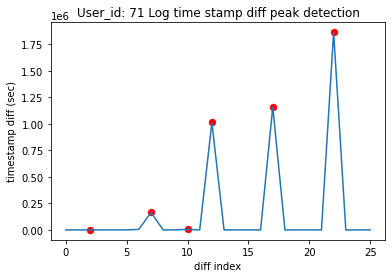

41it [00:01, 22.37it/s]


In [32]:
user_seq_df_list = list()
for idx, (user_id, user_log_df) in tqdm(enumerate(user_group_obj)):
    
    log_time_diff = np.diff(user_log_df.timestamp).astype('timedelta64[s]').astype(np.float64)
    
    c_max_index_arr = argrelextrema(
        data=log_time_diff,
        comparator=np.greater,
        order=1
        )
    
    if is_plot:
        plt.plot(log_time_diff)
        plt.scatter(c_max_index_arr[0],log_time_diff[c_max_index_arr[0]],linewidth=0.3, s=50, c='r')
        plt.title(f"User_id: {user_id} Log time stamp diff peak detection")
        plt.xlabel("diff index")
        plt.ylabel("timestamp diff (sec)")
        plt.show()
    
    # PD 기반 sequence 저장 
    sequence_df_list = list()
    for index, c_max_index in enumerate(c_max_index_arr[0]):
        if index == len(c_max_index_arr[0]) - 1:
            break
        sequence_df = user_log_df[c_max_index+1:c_max_index_arr[0][index+1]+1]
        sequence_df_list.append(sequence_df)

    # 잘못 잘린 sequence 후처리
    if len(sequence_df_list) == 0:
        continue 
    
    prev_sequence_df = sequence_df_list[0]
    fixed_sequence_df_list = list()
    for index, curr_sequence_df in enumerate(sequence_df_list[1:], 1):
        first_event = curr_sequence_df.event.values[0]
        if first_event == 'OpenApp':
            fixed_sequence_df_list.append(curr_sequence_df)
            prev_sequence_df = curr_sequence_df
        else:
            if len(fixed_sequence_df_list) == 0:
                continue
            curr_start_timestamp = curr_sequence_df.timestamp.iloc[0]
            prev_end_timestamp = prev_sequence_df.timestamp.iloc[-1]
            curr_prev_time_diff = (curr_start_timestamp - prev_end_timestamp)
            merge_condition = abs(curr_prev_time_diff) <= pd.Timedelta(hours=1)
            if merge_condition:
                last_sequence_df = fixed_sequence_df_list.pop()
                concated_sequence_df = pd.concat([last_sequence_df, curr_sequence_df])
                fixed_sequence_df_list.append(concated_sequence_df)
                
    # 이상한 OpenApp 삭제
    final_seq_df_list = []
    for seq_df in fixed_sequence_df_list:
        first_event = seq_df.event.values[0]
        if first_event == "OpenApp":
            final_seq_df_list.append(seq_df)
    
    if len(final_seq_df_list) != 0:
        user_seq_df_list.append(final_seq_df_list)
        
    break

In [37]:
final_seq_df_list[0]

,user_id,event,timestamp
9359739,71,OpenApp,2022-05-08 20:07:59
9359761,71,StartLoanApply,2022-05-08 20:08:11
9359762,71,ViewLoanApplyIntro,2022-05-08 20:08:11


In [38]:
final_seq_df_list[1]

,user_id,event,timestamp
11343004,71,OpenApp,2022-05-20 15:09:59
11343078,71,StartLoanApply,2022-05-20 15:10:25
11343081,71,ViewLoanApplyIntro,2022-05-20 15:10:25
11343159,71,CompleteIDCertification,2022-05-20 15:10:50
11343350,71,EndLoanApply,2022-05-20 15:11:58


In [39]:
final_seq_df_list[2]

,user_id,event,timestamp
13189887,71,OpenApp,2022-06-03 01:24:59
13189897,71,ViewLoanApplyIntro,2022-06-03 01:25:14
13189899,71,StartLoanApply,2022-06-03 01:25:14
13189922,71,CompleteIDCertification,2022-06-03 01:25:39
13189963,71,EndLoanApply,2022-06-03 01:26:41


In [34]:
sequence_df_list[0]

,user_id,event,timestamp
9213000,71,ViewLoanApplyIntro,2022-05-06 20:57:00
9213001,71,StartLoanApply,2022-05-06 20:57:00
9213050,71,CompleteIDCertification,2022-05-06 20:57:43
9213241,71,EndLoanApply,2022-05-06 20:59:48
9220373,71,OpenApp,2022-05-06 22:21:20


In [35]:
sequence_df_list[1]

,user_id,event,timestamp
9359739,71,OpenApp,2022-05-08 20:07:59
9359761,71,StartLoanApply,2022-05-08 20:08:11
9359762,71,ViewLoanApplyIntro,2022-05-08 20:08:11


In [31]:
import pickle
with open("fixed_sequence.pkl", "wb") as save_file:   #Pickling
    pickle.dump(user_seq_df_list, save_file)

In [7]:
user_seq_df_list = pd.read_pickle("fixed_sequence.pkl")

## 검증
1. 최대길이확인
2. OpenApp으로 시작하지 않는 sequence 존재하는지

In [8]:
max_seq_len = 0
total_seq_count = 0 
for idx, seq_df_list in enumerate(user_seq_df_list):
    user_id = seq_df_list[0].user_id.unique()[0]
    
    # 1. 최대 길이 저장
    for seq_df in seq_df_list:
        max_seq_len = len(seq_df) if len(seq_df) > max_seq_len else max_seq_len
    
    # 2. OpenApp으로 시작하지 않는 sequence 존재하는지 확인
    for seq_idx, seq_df in enumerate(seq_df_list):
        first_event = str(seq_df.event.iloc[0])
        if first_event != 'OpenApp':
            print(f'🚫 User#{user_id} : Seq#{seq_idx}')
    
    total_seq_count += len(seq_df_list)

## 단순 통계치 확인

In [27]:
user_event_series_list = []
for idx, (user_id, user_log_df) in tqdm(enumerate(user_group_obj)):
    a = user_log_df.event.value_counts()
    b = pd.DataFrame(a).T.reset_index(drop=True)
    b['user_id'] = user_id
    user_event_series_list.append(b)

584636it [11:22, 856.07it/s]


In [28]:
total_df = pd.concat(user_event_series_list)

In [30]:
total_df

,GetCreditInfo,Login,UseLoanManage,CompleteIDCertification,EndLoanApply,OpenApp,SignUp,StartLoanApply,UseDSRCalc,UsePrepayCalc,ViewLoanApplyIntro,user_id
0,3,1,1,0,0,0,0,0,0,0,0,1
0,1,0,0,0,0,0,0,0,0,0,0,7
0,3,0,0,0,0,0,0,0,0,0,0,9
0,8,0,9,4,7,5,0,4,0,1,5,11
0,5,15,1,15,39,15,0,15,0,0,15,12
...,...,...,...,...,...,...,...,...,...,...,...,...
0,2,0,5,6,12,9,0,17,0,0,10,879693
0,0,0,0,1,3,0,0,1,0,0,1,879694
0,0,0,0,1,1,0,0,1,0,0,1,879695
0,3,2,2,1,1,1,0,0,0,0,1,879696
